# Area of Interest (AOI) generator

Use this when geoTIFF image folders do not already have a corresponding AOI folder.
This will populate every single image folder with an AOI folder containing a single geoJSON file

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [4]:
from google.cloud import storage

from utils import gcp_utils
from utils.data_management import get_annotation_path
from utils.labelbox_utils import get_annotation_objects_from_data_row_export, get_geojson_fc_from_annotation_objects
import rasterio
from rasterio.plot import show
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [5]:
# Load environment variables from .env.
# Alternatively, manually set environment variables.

from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from project_config import GCP_PROJECT_NAME
gcp_client = storage.Client(project=GCP_PROJECT_NAME)

BUCKET_NAME = 'sand_mining_test'

In [7]:
observations = gcp_utils.list_subfolders(gcp_client, 'labels', 'sand_mining_test')

In [25]:
def generate_aoi(raster_path:str, river_areas:gpd.GeoDataFrame, buffer_deg=0.01, tolerance = 0.01, display=False):
    """
    Given a vector containing the full set of river_areas and a target raster, this function generates a simplified
    area of interest around the section of the river within the raster.
    :param raster_path: a string containing the path to the target raster
    :param river_areas: A geopandas dataframe containing the river areas
    :param buffer_deg: The buffer distance in degrees
    :return: A geopandas dataframe containing the simplified area of interest
    """

    # Get the bounds of the raster
    with rasterio.open(raster_path) as src:
        raster = src.read()
        bounds = src.bounds

    #make sure the river areas are in the same crs as the raster
    river_areas = river_areas.to_crs(rasterio.open(raster_path).crs)
    # Clip the river areas to the bounds of the raster
    river_window = river_areas.clip(bounds)

    if display:
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        show(raster, ax=ax, transform=src.transform)
        river_window.geometry.boundary.plot(ax=ax, zorder =2)
    


    #check if river_window is empty, if so return an empty geodataframe, and raise a warning
    if river_window.empty:
        print('Warning: river window is empty')
        return gpd.GeoDataFrame()

    # Merge all the geometries in the river window
    merged_geometry = unary_union(river_window.geometry)

    # Buffer & simplify the merged geometry to simplify it
    simplified_geometry = merged_geometry.buffer(buffer_deg).simplify(tolerance)

    #simplify the geometry
    # simplified_geometry = simplified_geometry.simplify(buffer_deg)

    # Convert the simplified geometry back to a GeoDataFrame
    simplified_river_window = gpd.GeoDataFrame(geometry=[simplified_geometry])

    #clip to the bounds
    simplified_river_window = simplified_river_window.clip(bounds)

    if display:
        simplified_river_window.geometry.boundary.plot(ax=ax, zorder=3, color='red')
        fig.show()

    return simplified_river_window


In [9]:
from project_config import RIVER_NETWORKS_DIR
import os

# Load the river networks

india_river_path = os.path.join(RIVER_NETWORKS_DIR, 'india-rivers_multipolygons.geojson')
india_rivers = gpd.read_file(india_river_path)
# india_rivers.plot()

In [10]:
india_rivers.head()

,full_id,osm_id,osm_type,water,imagery_used,hazard_type,hazard_return_period,hazard_prone,floodplain_probability,floodplain_issue,...,name:az-Arab,name:arz,name:ar,tidal,name,intermittent,fishing,type,natural,geometry
0,r4045,4045,relation,river,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon,water,"MULTIPOLYGON (((73.07805 21.73698, 73.07875 21..."
1,r4048,4048,relation,river,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon,water,"MULTIPOLYGON (((72.82154 21.65952, 72.82142 21..."
2,r4068,4068,relation,river,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon,water,"MULTIPOLYGON (((73.01605 19.71603, 73.01623 19..."
3,r4070,4070,relation,river,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon,water,"MULTIPOLYGON (((72.98961 19.62702, 72.99016 19..."
4,r4079,4079,relation,river,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon,water,"MULTIPOLYGON (((72.99416 18.46385, 72.99415 18..."


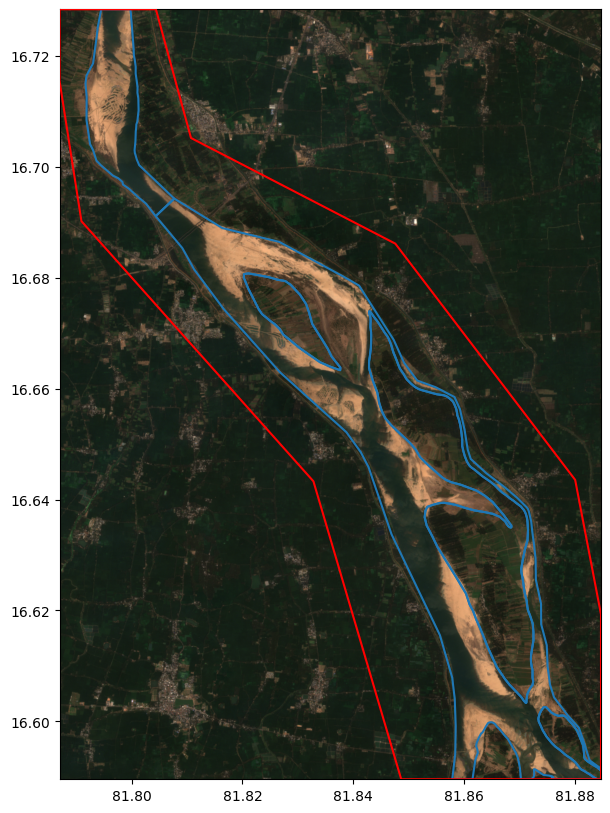

In [27]:
# for every observation (which is a folder), go to the subfolder 'rgb' and grab the path to the first image to get the bounds


for obs in observations:
    #append '/rgb' to the observation path
    rgb_folder = 'labels/' + obs + '/rgb/'
    #get the path to the first image in the folder
    blob = gcp_utils.list_files_in_folder(gcp_client, rgb_folder, BUCKET_NAME)[0]
    #convert from blob to filepath
    # get the name of the blob
    raster_path = gcp_utils.get_public_url(blob.name, BUCKET_NAME)
    # print(raster_path)
    # bounds = rasterio.open(raster_path).bounds
    # print(bounds)
    aoi = generate_aoi(raster_path, india_rivers,display=True)
    # aoi.boundary.plot()

